# Spatial Integration of MSI and MSI

In this notebook we show that MIIT can also be used to integrate different types of MSI data. In this example, we load two random datasets, one present msi data retrieved in 
positive ion mode (imzml_pos) and the other msi data retrieved in negative ion mode (imzml_neg). Then we register and transform imzml_neg into the image of imzml_pos and export the result data as an imzML file.

In the previous tutorial, we combined all data into `Section` objects that allow to contain multiple data in the same image space. However, when only
working with one type of data, we can also use that data type directly instead of embedding into a `Section`. 

Note, that this function is still experimental at this point.

In [11]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from miit.spatial_data.image import DefaultImage
from miit.spatial_data.spatial_omics.imzml import Imzml, export_imzml
from miit.registerers import GreedyFHistExt

### Load Data

In [2]:
# First we load our target data: Imzml containing msi data retrieved in positive ion mode.
reference_image_np = data=sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section2/reference_image.tif'))
reference_image = DefaultImage(data=reference_image_np)
msi_pos_image_path = '../data/hist/section2/reference_image.tif'
msi_pos_image = DefaultImage(data=sitk.GetArrayFromImage(sitk.ReadImage(msi_pos_image_path)))
imzml_pos_path = '../data/msi_pos/data.imzML'
imzml_pos = Imzml.load_msi_data(msi_pos_image, imzml_pos_path, name='positive ion mode')

# Next, we load the data source data: Imzml containing msi data retrieved in negative ion mode.
msi_neg_hist_image_path = '../data/hist/section3/reference_image.tif'
msi_neg_hist_image = DefaultImage(data=sitk.GetArrayFromImage(sitk.ReadImage(msi_neg_hist_image_path)))
imzml_path = '../data/msi_neg/data.imzML'
imzml_neg = Imzml.load_msi_data(msi_neg_hist_image, imzml_path, name='negative ion mode')

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Histology MSI positive ion mode.')

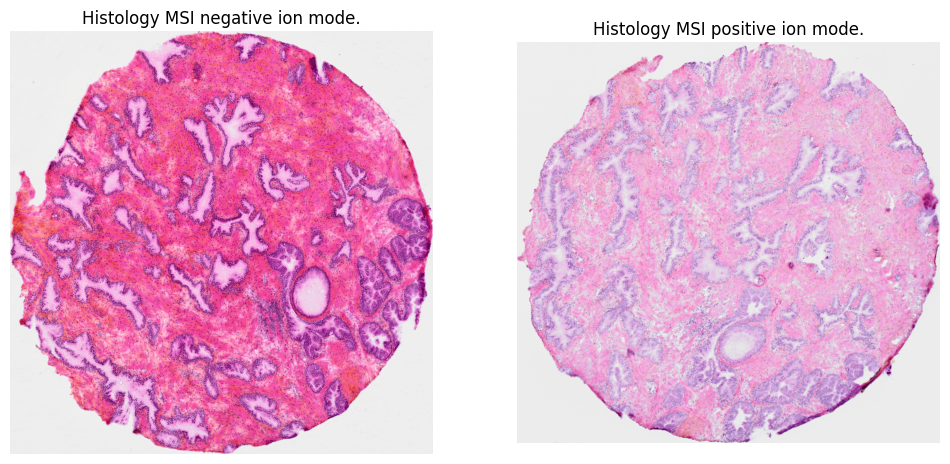

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(imzml_neg.image.data)
axs[0].set_title('Histology MSI negative ion mode.')
axs[1].imshow(imzml_pos.image.data)
axs[1].set_title('Histology MSI positive ion mode.')


### Registration

In [4]:
registerer = GreedyFHistExt.load_from_config()

transformation = registerer.register_images(
    moving_img=imzml_neg.image.data,
    fixed_img=imzml_pos.image.data
)

warped_imzml = imzml_neg.warp(registerer, transformation)

Text(0.5, 1.0, 'Registered negative ion mode msi section')

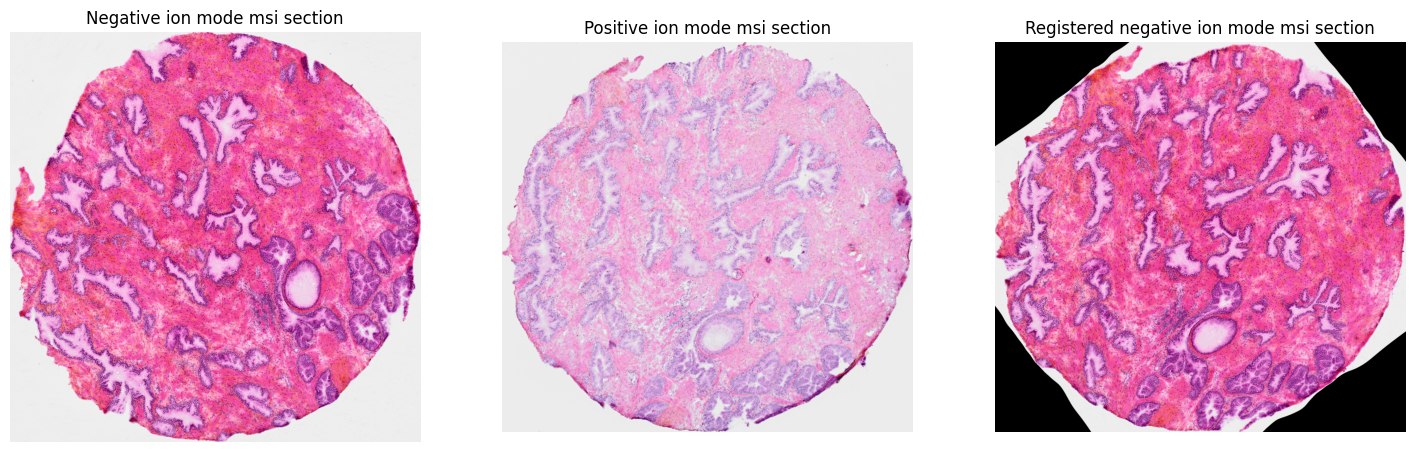

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(imzml_neg.image.data)
axs[0].set_title('Negative ion mode msi section')
axs[1].imshow(imzml_pos.image.data)
axs[1].set_title('Positive ion mode msi section')
axs[2].imshow(warped_imzml.image.data)
axs[2].set_title('Registered negative ion mode msi section')

### Integration of negative and positive ion mode msi

In [6]:
from miit.spatial_data.spatial_omics.imzml import (
    get_metabolite_intensities_targeted, 
    msi_default_accumulate_spot_weighted_mean, 
    msi_default_spot_accumulation_fun
)
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts,
    integrate_annotations
)
from pyimzml.ImzMLParser import ImzMLParser

In [7]:
msi_pos_data = imzml_pos
msi_neg_data = warped_imzml
mappings, spots_background, unique_target_reference = get_mappings(msi_pos_data.ref_mat.data, msi_neg_data.ref_mat.data, msi_pos_data.background, msi_neg_data.background)

In [8]:
msi_pixel_idxs = msi_neg_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_neg_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_neg_data.config['imzml'])
msi_pos = ImzMLParser(msi_pos_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs)
metabolites_df.head()

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


,14,15,16,17,19,24,25,26,30,31,...,7342,7343,7344,7345,7346,7347,7348,7349,7350,7351
0.000,3.999305,114.745522,2.737278,0.443141,1.529948,0.657107,0.475049,176.447083,3.259485,1.986200,...,2.175754,16.366716,1.394977,1.902068,15.230617,0.791088,1.115425,0.975474,0.618040,1.144877
1.000,0.878601,1.010871,1.071593,3.974809,0.828472,0.806916,129.248825,2.108558,1.378976,3.467360,...,4.068408,5.068223,1.996402,22.860813,0.559155,0.680954,1.619306,1.231109,185.002304,0.328367
2.000,1.084637,1.308292,9.863456,7.330612,2.051691,0.240061,0.994729,2.254210,1.166681,1.125686,...,5.024716,7.526261,2.008492,3.001752,1.364704,1.899235,2.489690,0.857228,4.353659,8.457427
3.000,0.571428,0.350466,2.064018,3.346106,1.248638,0.310404,0.631537,0.527299,206.125702,1.036382,...,11.781754,2.141965,14.744335,3.055336,0.528222,1.403921,2.618337,1.341296,1.505044,1.102066
4.000,9.233212,0.529808,2.978517,1.334822,2.020700,0.858339,0.802621,0.452567,0.210428,192.959717,...,15.919563,9.601240,5.312617,0.529010,2.521801,7.205492,1.606848,13.883173,1.776496,1.371707


In [9]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, msi_neg_data)
integrated_df.head()

,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,...,30.000,31.000,32.000,33.000,34.000,35.000,36.000,37.000,38.000,39.000
2732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
export_imzml(msi_pos, 'integrated_msi_neg.imzML', integrated_df)